In [1]:
#Data Preparation

In [23]:
import pandas as pd
#load osm data for KC
kc_osm_data = pd.read_csv('../../data/data_ohsome/new_kc_osm.csv')
#Melt the dataframe
value_vars = ['properties.amenity', 'properties.healthcare', 'properties.office', 'properties.historic', 'properties.natural', 
              'properties.shop', 'properties.tourism', 'properties.leisure', 'properties.sport', 'properties.aeroway', 'properties.man_made', 
              'properties.waterway']
id_vars = [x for x in kc_osm_data.columns if x not in value_vars]
kc_osm_data2 = pd.melt(kc_osm_data, 
                       id_vars=id_vars, 
                       value_vars=value_vars, 
                       var_name= 'key',
                       value_name= 'value')
#remove none values from tags
kc_osm_data2 = kc_osm_data2.dropna(subset=['value']) 
#select certain columns
kc_osm_data2 = kc_osm_data2[["geometry.coordinates", "properties.@osmId", "key", "value"]]
#convert to geopandas dataframe
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
kc_osm_data2['geometry.coordinates'] = kc_osm_data2['geometry.coordinates'].apply(lambda x: Point(eval(x)))
kc_osm_data2 = gpd.GeoDataFrame(kc_osm_data2, geometry = 'geometry.coordinates', crs="EPSG:4326").to_crs('epsg:27700')

C:\Users\smn18\AppData\Local\Temp\ipykernel_20120\2840804449.py:3: DtypeWarning: Columns (8,11,24,31,44,57,62,64,77,79,81,82,83,84,85,86,87,89,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,122,123,124,125,126,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,144,145,146,148,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,259,260,261,262,263,265,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,293,294,295,296,297,298,299,300,301,303,304,305,307,309,310,311,312,314,316,317,318,319,320,321,322,323,

In [24]:
#Run spatial clustering using DBSCAN

In [25]:
#Prepare dataset
from shapely.geometry import MultiPoint
#remove unnecessary values 
kc_osm_data2 = kc_osm_data2[~(kc_osm_data2.value.isin(["yes"]))]
kc_osm_data2['easting'] = kc_osm_data2['geometry.coordinates'].x
kc_osm_data2['northing'] = kc_osm_data2['geometry.coordinates'].y
kc_coords = kc_osm_data2[['easting', 'northing']].to_numpy()

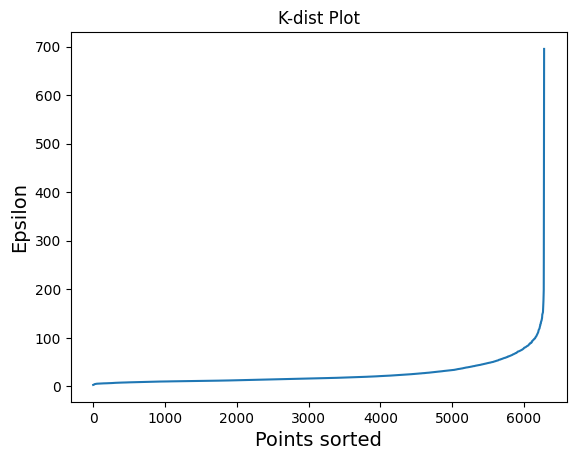

In [26]:
#finding the optimum epsilon
#Codes inspired from https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(kc_coords)
#distance between each point and its k nearest neighbour
distances, indices = neighbors_fit.kneighbors(kc_coords)
#sort distances in ascending order
distances = np.sort(distances, axis=0)
distances = distances[:,3]
#plot distances
plt.title('K-dist Plot')
plt.xlabel('Points sorted', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)


In [27]:
#run dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=60, min_samples=4, metric='euclidean') 
db = dbscan.fit(kc_coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
num_noise = list(cluster_labels).count(-1)
print(num_clusters)
print(num_noise)

100
367


In [29]:
#run dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=60, min_samples=4, metric='euclidean') 
db = dbscan.fit(kc_coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
num_noise = list(cluster_labels).count(-1)
print(num_clusters)
print(num_noise)#add cluster labels to dataset
kc_osm_data2['cluster'] = cluster_labels
#remove noise
remove = kc_osm_data2[kc_osm_data2['cluster'] == -1].index
kc_osm_data2 = kc_osm_data2.drop(remove)

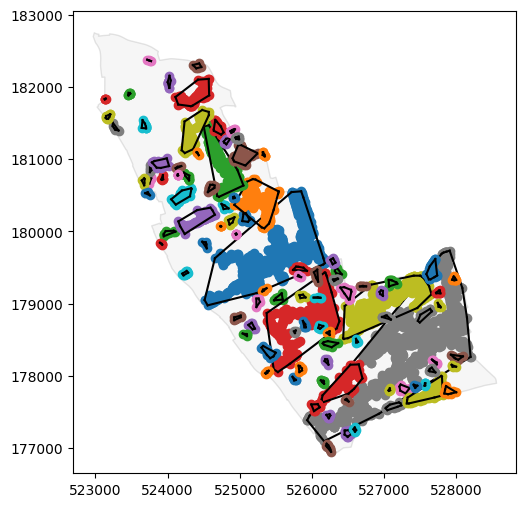

In [31]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = kc_osm_data2[["easting",
                   "northing",
                   "cluster"]]
import geopandas as gpd
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=27700).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,99):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["easting", "northing"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o') #plot the points
    #plot the simplices (indices of points that forms the facets of the convexhull)
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-') 
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)


In [ ]:
#Create ordered-sequence of POIs for input into LDA

In [46]:
#get tag list for each dbscan cluster as a list
osm_kc_dbscan = kc_osm_data2.groupby('cluster')['value'].apply(list)
data_dbscan = pd.DataFrame(osm_kc_dbscan)
tag_list_dbscan = data_dbscan.value.values.tolist()
data_dbscan.to_csv('../../docs/docs_agile/kc_osm_dbscan_tag.csv')

In [ ]:
#Start LDA topic modeling

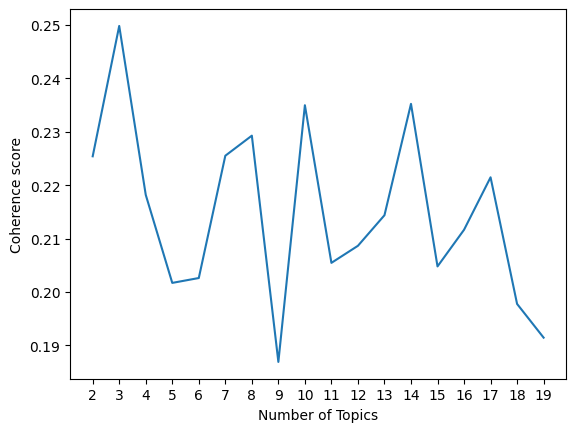

In [33]:
#calculate coherence value for differenct topic number
#Code inspired from https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
#gensim reference: https://radimrehurek.com/gensim/models/coherencemodel.html
#https://radimrehurek.com/gensim/models/ldamodel.html
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
# Create a corpus from a list of texts
dictionary = Dictionary(tag_list_dbscan)
corpus = [dictionary.doc2bow(text) for text in tag_list_dbscan]
coherence_values = []
def coherence_value(dictionary, texts, corpus, start, stop, step):
    for num_topics in range(start, stop, step):
        lda_model = LdaModel(corpus=corpus,
                              num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        texts = texts,
                                        coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)

    return coherence_values

#run the function to find optimum number of topics
coherence_values = coherence_value(dictionary=dictionary, 
                                   corpus=corpus, 
                                   texts = tag_list_dbscan,
                                   start=2, 
                                   stop=20, 
                                   step=1)

#plot as graph
x = range(2, 20)
plt.plot(x, coherence_values)
plt.xticks(x)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()
    

In [42]:
#build lda with optimum topic number
lda_model_osm = LdaModel(corpus=corpus, 
                      num_topics=10,
                      id2word = dictionary)
#print the topic term distribution
lda_model_osm.show_topics(num_words = 10)

[(0,
  '0.086*"bicycle_parking" + 0.048*"post_box" + 0.043*"memorial" + 0.040*"bench" + 0.039*"estate_agent" + 0.038*"convenience" + 0.038*"motorcycle_parking" + 0.036*"cafe" + 0.034*"beauty" + 0.034*"hairdresser"'),
 (1,
  '0.231*"memorial" + 0.038*"post_box" + 0.034*"bicycle_parking" + 0.024*"tree" + 0.022*"motorcycle_parking" + 0.020*"clothes" + 0.019*"parking" + 0.018*"doctor" + 0.018*"doctors" + 0.017*"diplomatic"'),
 (2,
  '0.121*"bicycle_parking" + 0.103*"bench" + 0.064*"clothes" + 0.053*"restaurant" + 0.053*"tree" + 0.043*"motorcycle_parking" + 0.027*"memorial" + 0.021*"estate_agent" + 0.017*"fast_food" + 0.017*"cafe"'),
 (3,
  '0.137*"bench" + 0.096*"bicycle_parking" + 0.079*"tree" + 0.064*"clothes" + 0.061*"restaurant" + 0.036*"post_box" + 0.029*"memorial" + 0.026*"telephone" + 0.020*"cafe" + 0.019*"hairdresser"'),
 (4,
  '0.096*"tree" + 0.085*"clothes" + 0.064*"bench" + 0.061*"bicycle_parking" + 0.053*"restaurant" + 0.031*"telephone" + 0.025*"cafe" + 0.022*"dentist" + 0.019*

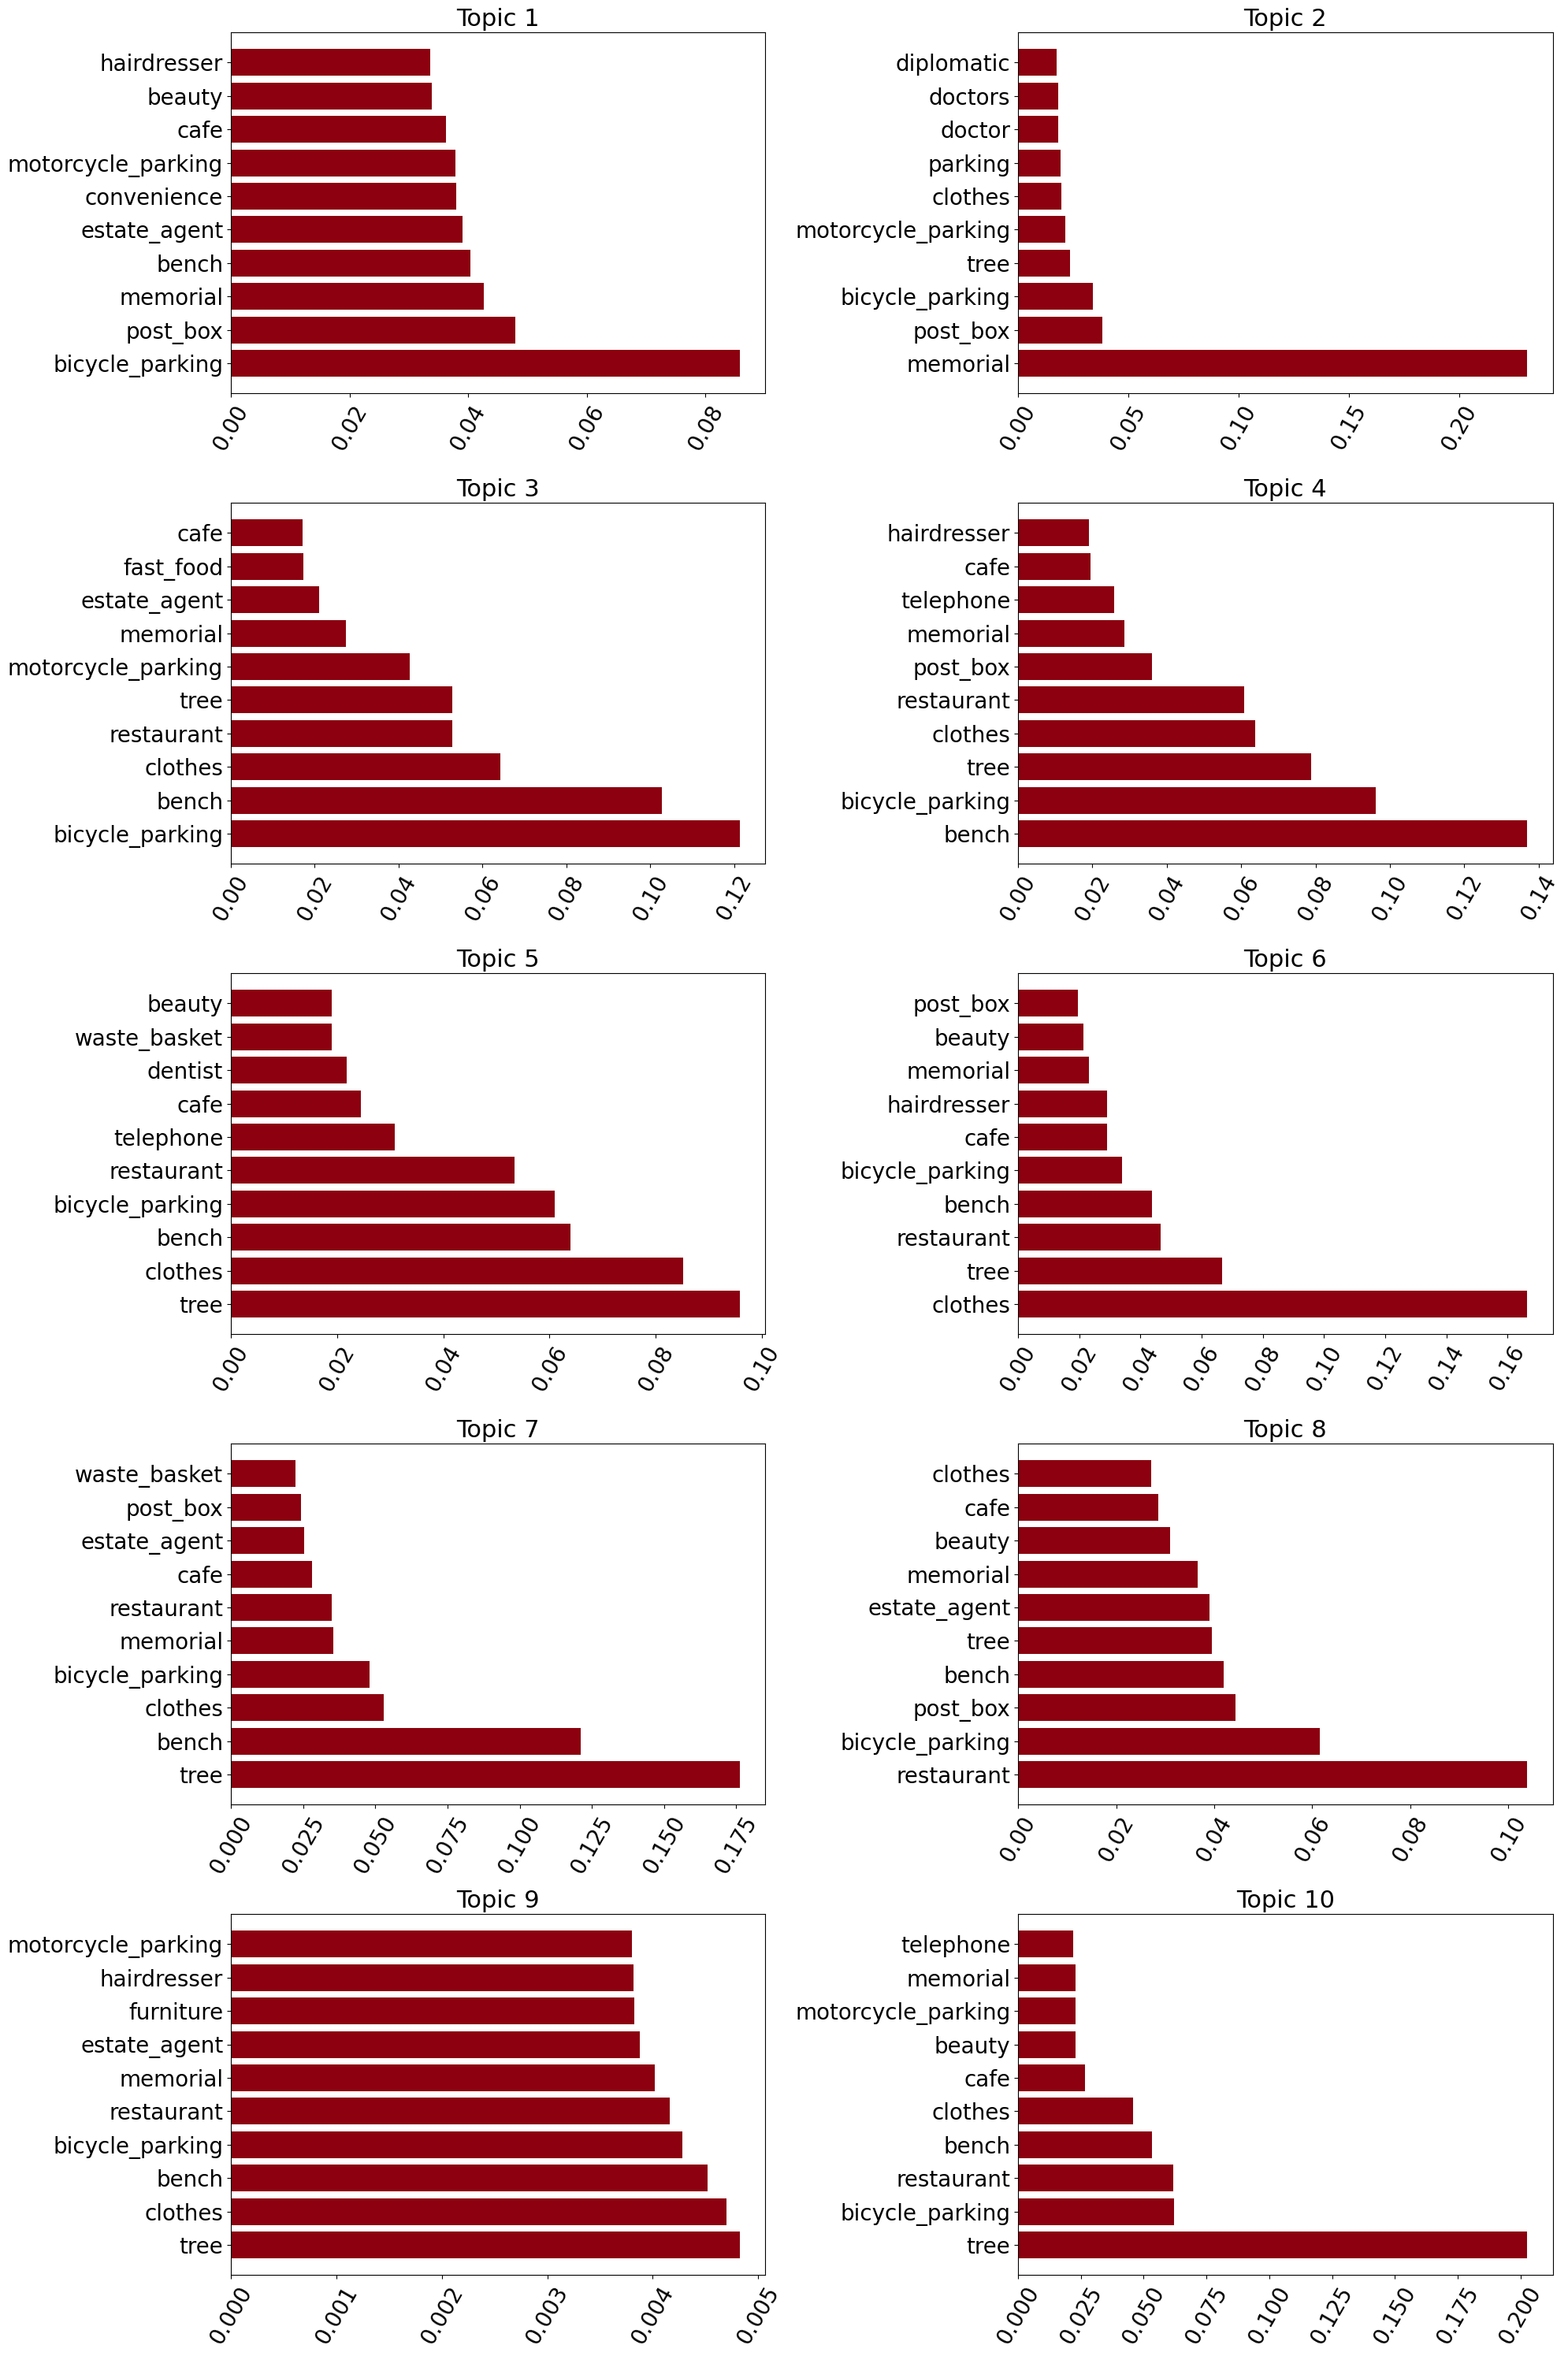

In [43]:
fig =plt.figure(figsize=(20,30))
fig_no = 0
for i in range(0,10):
    df=pd.DataFrame(lda_model_osm.show_topic(i, topn = 10), 
                    columns=['term','probability'])
    plt.subplot(5,2,i+1)
    plt.title('Topic '+str(i+1), fontsize = 22)
    plt.barh(df['term'], df['probability'],
                 color = "#8C000F")
    plt.xlabel = 'Term'
    plt.ylabel = 'Probability'
    plt.xticks(rotation= 60, fontsize = 20)
    plt.yticks(fontsize=20)
    fig.tight_layout()
    fig_no += 1
    bar_plot = '../../docs/docs_agile/kc_osm_lda' + str(fig_no) + '.png'
    plt.savefig(bar_plot)


plt.show()

In [39]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_osm, 
                                     texts=tag_list_dbscan, 
                                     dictionary=dictionary, 
                                     coherence='c_uci')
coherence_score = coherence_model_lda.get_coherence()
coherence_score

-4.25770292010988

In [40]:
#Topic distribution for each dbscan cluster
all_topics = lda_model_osm.get_document_topics(corpus)
num_docs = len(all_topics)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
colnames = ['Topic'+str(i+1) for i in range(0,10)]
all_topics_df = pd.DataFrame(all_topics_numpy, columns = colnames)
#find the dominant topic for each DBSCAN cluster
all_topics_df['Topic'] = all_topics_df[colnames].idxmax(axis=1)
all_topics_df

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic
0,0.000000,0.000000,0.000000,0.000000,0.997056,0.000000,0.000000,0.000000,0.000000,0.000000,Topic5
1,0.020004,0.020004,0.020004,0.020004,0.020004,0.020005,0.020000,0.819968,0.020002,0.020005,Topic8
2,0.000000,0.000000,0.000000,0.224259,0.000000,0.000000,0.000000,0.743733,0.000000,0.000000,Topic8
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.998109,0.000000,0.000000,Topic8
4,0.011113,0.011114,0.011113,0.011113,0.011114,0.011113,0.011111,0.899981,0.011113,0.011113,Topic8
...,...,...,...,...,...,...,...,...,...,...,...
94,0.000000,0.000000,0.000000,0.000000,0.918171,0.000000,0.000000,0.000000,0.000000,0.000000,Topic5
95,0.016672,0.016671,0.849965,0.016671,0.016674,0.016670,0.016667,0.016671,0.016668,0.016672,Topic3
96,0.014288,0.014287,0.014290,0.014288,0.871412,0.014287,0.014286,0.014287,0.014287,0.014287,Topic5
97,0.016670,0.016669,0.849975,0.016670,0.016673,0.016669,0.016668,0.016669,0.016668,0.016669,Topic3


In [41]:
##add c_h polygon coordinates
all_topics_df['geometry'] = c_h
#set index as column
all_topics_df['cluster'] = all_topics_df.index

In [44]:
#add topic labels
#Name the lda topics
def get_osm_topic_name(topic):
    if topic == 'Topic1':
        return 'Local Shopping Street'
    elif topic == 'Topic2':
        return 'Embassy and High Commission'
    elif topic == 'Topic3':
        return 'Eateries'
    elif topic == 'Topic5':
        return 'High Street Shopping'
    elif topic == 'Topic6':
        return 'High Street Shopping'
    elif topic == 'Topic8':
        return 'Eateries'
    else:
        return 'Others'
all_topics_df['LDA_Topic_OSM'] = all_topics_df['Topic'].apply(get_osm_topic_name)

In [ ]:
#Spatial Distribution of LDA topics

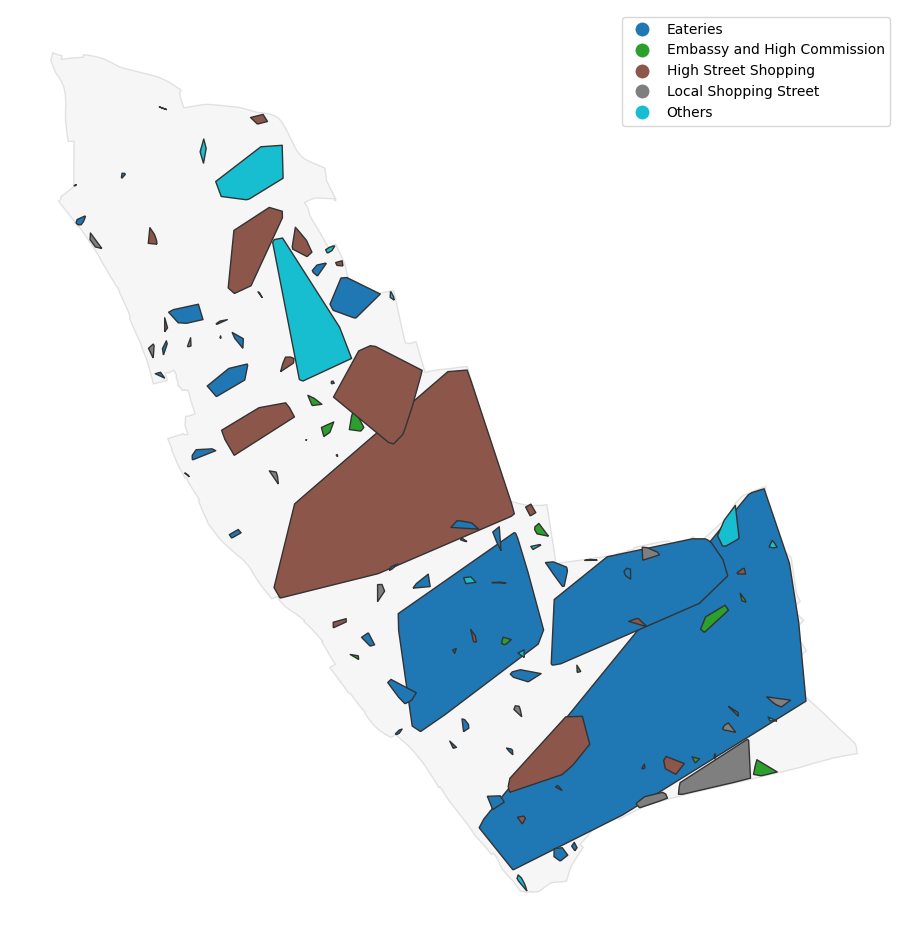

In [45]:
all_topics_gdf_osm = gpd.GeoDataFrame(all_topics_df, geometry="geometry", crs='EPSG:27700')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 12))
kc_boundary.to_crs(epsg=27700).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
all_topics_gdf_osm.plot(column='LDA_Topic_OSM', 
                      categorical = True  , 
                      edgecolor='0.2',
                      cmap='tab10', 
                      ax=ax, 
                      legend = True
                      
                     )
ax.set_axis_off()


In [48]:
#Bring BTM topic distribution run on R
##calling the saved kc_osm data from the folder
import pandas as pd
#load osm data for KC
kc_osm_topic_df = pd.read_csv('../../docs/docs_agile/topic_prob_kc_osm.csv')

In [49]:
##add c_h polygon coordinates
kc_osm_topic_df['geometry'] = c_h
#set index as column
kc_osm_topic_df['cluster'] = kc_osm_topic_df.index

In [50]:
#add topic labels
#Name the lda topics
def get_osm_topic_name(topic):
    if topic == 'V1':
        return 'Park & Green Spaces'
    elif topic == 'V2':
        return 'Eateries' 
    elif topic == 'V3':
        return 'Park & Green Spaces'  
    elif topic == 'V4':
        return 'Local Shopping Street' 
    elif topic == 'V5':
        return 'Diplomatic mission and commercial services'
    elif topic == 'V6':
        return 'Antiques and furniture shops'
    elif topic == 'V8':
        return 'High Street Shopping'
    elif topic == 'V10':
        return 'Sports facilities, Gallery & Artwork'
    else:
        return 'Mixed Functions'
kc_osm_topic_df['BTM_topic_osm'] = kc_osm_topic_df['Topic'].apply(get_osm_topic_name)


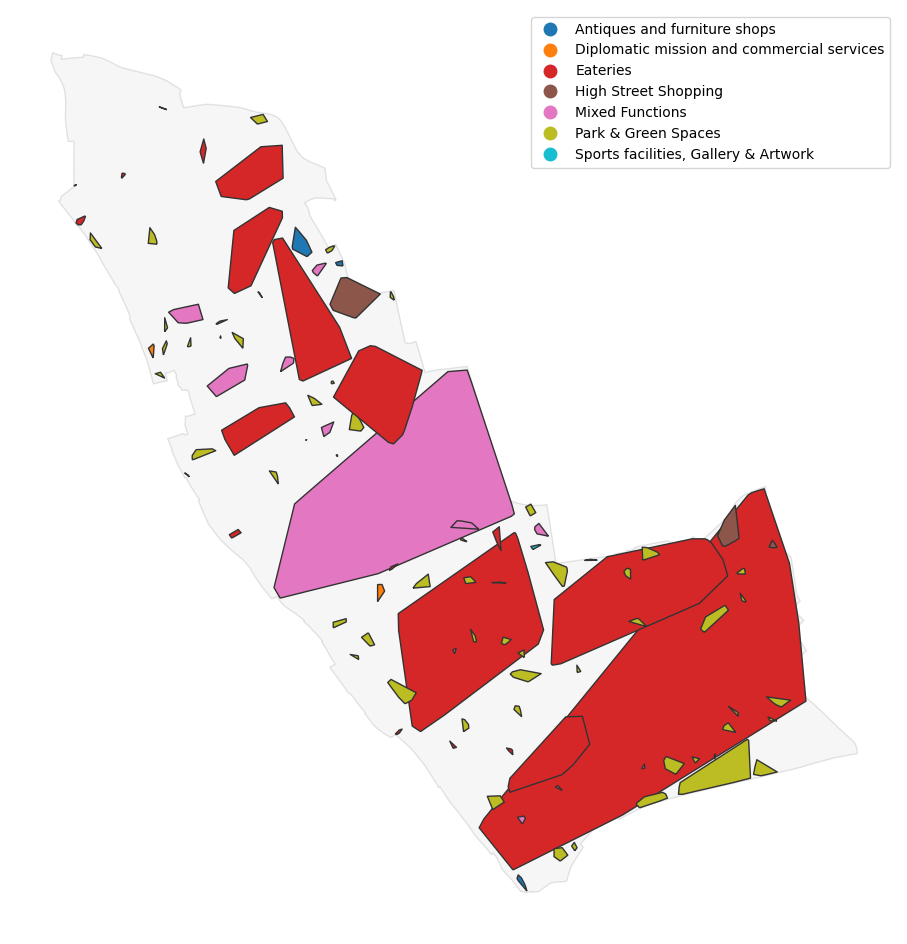

In [51]:
#Mapping
kc_osm_topic_gdf = gpd.GeoDataFrame(kc_osm_topic_df, geometry="geometry", crs='EPSG:27700')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 12))
kc_boundary.to_crs(epsg=27700).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
kc_osm_topic_gdf.plot(column='BTM_topic_osm', 
                      categorical = True  , 
                      edgecolor='0.2',
                      cmap='tab10', 
                      ax=ax, 
                      legend = True
                     )
ax.set_axis_off()

In [52]:
kc_osm_topic_gdf.to_csv('../../docs/docs_agile/osm_kc_btm_topics_agile.csv')